### Table of Content

[1. Decision Tree Codes](#dt1) <br>

[2. Comparison with Scikit-Learn](#dt2) <br>


## <a id='dt1'></a> 1. Decision Tree Codes

In [1]:
import numpy as np
import pandas as pd

In [2]:
def entropy(y):
    """
    Calculate the entropy at each node
    Inputs: 
        y - numpy.ndarray, array of labels in the node. e.g., array([0, 1, 1, 1, 1]) in root node
    Outputs: 
        entropy - float, the calculated entropy value
    """
    _, counts = np.unique(y, return_counts=True) # return_counts : bool, optional. 
                                                 # If True, also return the number of times each unique item appears
    probabilities = counts / len(y)
    entropy = np.sum( -(probabilities * np.log2(probabilities)) )
    return entropy

In [3]:
def split_data(X, y, feature_idx, value):
    """
    Split the dataset into two subsets (left and right) based on the given feature index and value
    Inputs: 
        X - numpy.ndarray, array of features
        y - numpy.ndarray, array of labels
        feature_idx - int, index of the feature to split on
        value - float, the value to split the dataset
    Outputs: 
        X_left, y_left - numpy.ndarray, the subset with feature values <= value
        X_right, y_right - numpy.ndarray, the subset with feature values > value
    """
    left_mask = X[:, feature_idx] <= value # mask using True and False
    right_mask = X[:, feature_idx] > value # mask using True and False
    return X[left_mask], y[left_mask], X[right_mask], y[right_mask]

In [4]:
def best_split(X, y, n_features):
    """
    Find the best split by iterating through all possible splits and calculating information gain
    Inputs: 
        X - numpy.ndarray, array of features
        y - numpy.ndarray, array of labels
        n_features - int, number of features
    Outputs: 
        best_gain - float, the best information gain found
        best_feature - int, index of the best feature to split on
        best_value - float, the best value to split the dataset
    """
    best_gain, best_feature, best_value = 0, None, None
    
    parent_entropy = entropy(y) # # Equation (5.2) in book: Entropy(parent)

    for feature_idx in range(n_features): # iterate all features
        values = np.unique(X[:, feature_idx])
        split_values = (values[:-1] + values[1:]) / 2  # Calculate the middle values between unique feature values
                                                       # e.g., values = [0,1,2]; ([0,1] + [1,2])/2 = [1,3]/2 = [0.5, 1.5]
        
        for value in split_values: # iterate all possible splits
            X_left, y_left, X_right, y_right = split_data(X, y, feature_idx, value)

            if len(y_left) == 0 or len(y_right) == 0:
                continue

            left_entropy = entropy(y_left)
            right_entropy = entropy(y_right)
            
            # Equation (5.2) in book: Weighted sum of Entropy(children)
            child_entropy = (len(y_left) / len(y)) * left_entropy + (len(y_right) / len(y)) * right_entropy

            # Equation (5.2) in book
            information_gain = parent_entropy - child_entropy

            if information_gain > best_gain:
                best_gain, best_feature, best_value = information_gain, feature_idx, value
    
    return best_gain, best_feature, best_value

In [5]:
# Recursive function to build the decision tree
def build_tree(X, y, n_features, max_depth, depth=0):
    """
    Recursively build the decision tree
    Inputs: 
        X - numpy.ndarray, array of features
        y - numpy.ndarray, array of labels
        n_features - int, number of features
        max_depth - int, maximum depth of the decision tree
    Outputs: 
        tree - dict, the built decision tree structure
    """
    if depth == max_depth or entropy(y) == 0 or len(y) <= 1:
        return {'label': np.argmax(np.bincount(y))} # bincount: count 0's occurences, 1's occurences, 2's, 3's
                                                    # argmax: return index of max value

    information_gain, feature, value = best_split(X, y, n_features) # returned feature is the index of the feature in feature_cols
    print(f"best split at depth {depth}: best_gain = {round(information_gain,3)}, split on {feature_cols[feature]} <= {value}")
    
    if information_gain == 0:
        return {'label': np.argmax(np.bincount(y))} 

    X_left, y_left, X_right, y_right = split_data(X, y, feature, value) # real split happens here after figure out which split give best gain
    # print("X_left, y_left\n", X_left, y_left)
    # print("X_right, y_right\n", X_right, y_right)
    
    return {
        'feature': feature,
        'value': value,
        'left': build_tree(X_left, y_left, n_features, max_depth, depth + 1),
        'right': build_tree(X_right, y_right, n_features, max_depth, depth + 1),
    }

In [6]:
def predict(tree, x):
    """
    Make predictions for a single instance using the decision tree
    Inputs: 
        tree - dict, the decision tree structure
        x - numpy.ndarray, a single feature instance
    Outputs: 
        prediction - int, the predicted label for the input instance
    """
    if 'label' in tree: # i.e., reached the leaf node
        return tree['label']

    feature = tree['feature']
    value = tree['value']

    # navigate to the left or right subtree (like how we explored binary tree)
    if x[feature] <= value:
        return predict(tree['left'], x) 
    else:
        return predict(tree['right'], x)

In [7]:
data = np.array([["rainy","hot","no"],
                 ["rainy","cool","yes"],
                 ["overcast","cool","yes"],
                 ["sunny","hot","yes"],
                 ["sunny","cool","yes"]])

col_names = ["Outlook","Temperature","Play_Tennis"]
data = pd.DataFrame(data, columns=col_names)
print("Original data:\n", data, "\n")

Original data:
     Outlook Temperature Play_Tennis
0     rainy         hot          no
1     rainy        cool         yes
2  overcast        cool         yes
3     sunny         hot         yes
4     sunny        cool         yes 



In [8]:
def label_encode_dataframe(data):
    """
    Perform label encoding on a pandas DataFrame by replacing categorical values with integer labels
    Inputs: 
        data - pandas.DataFrame, the input DataFrame with categorical values
    Outputs:
        encoded_data - pandas.DataFrame, the DataFrame with integer labels instead of categorical values
    """
    encoded_data = data.copy()
    for column in encoded_data.columns:
        unique_values = sorted(encoded_data[column].unique())
        value_to_int = {value: idx for idx, value in enumerate(unique_values)}
        encoded_data[column] = encoded_data[column].map(value_to_int)
    return encoded_data

data = label_encode_dataframe(data)
print("Encoded data:\n", data, "\n")

Encoded data:
    Outlook  Temperature  Play_Tennis
0        1            1            0
1        1            0            1
2        0            0            1
3        2            1            1
4        2            0            1 



In [9]:
feature_cols = ["Outlook", "Temperature"]
X = data[feature_cols].to_numpy()                               
y = data["Play_Tennis"].to_numpy()

tree = build_tree(X, y, n_features=len(feature_cols), max_depth=3)

best split at depth 0: best_gain = 0.322, split on Temperature <= 0.5
best split at depth 1: best_gain = 1.0, split on Outlook <= 1.5


In [10]:
## print("\n------------------first approach visualizing the tree-------------------")
import pprint
pprint.pprint(tree)

{'feature': 1,
 'left': {'label': 1},
 'right': {'feature': 0,
           'left': {'label': 0},
           'right': {'label': 1},
           'value': 1.5},
 'value': 0.5}


In [11]:
# Visualize the decision tree
def print_tree(tree, feature_names, spacing=""):
    if 'label' in tree:
        print(f"{spacing}Predict: {'Play_Tennis no' if tree['label'] == 0 else 'Play_Tennis yes'}")
        return

    feature = tree['feature']
    value = tree['value']

    print(f"{spacing}[{feature_names[feature]} <= {value}]")

    print(f"{spacing}-> True:")
    print_tree(tree['left'], feature_names, spacing + "\t")

    print(f"{spacing}-> False:")
    print_tree(tree['right'], feature_names, spacing + "\t")

print("\n------------------second approach visualizing the tree-------------------")
print_tree(tree, feature_cols)


------------------second approach visualizing the tree-------------------
[Temperature <= 0.5]
-> True:
	Predict: Play_Tennis yes
-> False:
	[Outlook <= 1.5]
	-> True:
		Predict: Play_Tennis no
	-> False:
		Predict: Play_Tennis yes


In [12]:
# Make predictions
predictions = [predict(tree, x) for x in X]
print("\nPredictions:", predictions, "\n")

# Calculate the accuracy
accuracy = np.sum(predictions == y) / len(y)
print("Accuracy:", accuracy, "\n")


Predictions: [0, 1, 1, 1, 1] 

Accuracy: 1.0 



## <a id='dt2'></a> 2. Comparison with Scikit-Learn

In [13]:
# Load libraries
import numpy as np
import pandas as pd
from sklearn import metrics 
from sklearn import tree
from sklearn import preprocessing
from sklearn.tree import DecisionTreeClassifier  
import matplotlib.pyplot as plt

In [14]:
data = np.array([["rainy","hot","no"],
                 ["rainy","cool","yes"],
                 ["overcast","cool","yes"],
                 ["sunny","hot","yes"],
                 ["sunny","cool","yes"]])
col_names = ["Outlook","Temperature","Play_Tennis"]
data = pd.DataFrame(data, columns=col_names)
print(data, "\n")

    Outlook Temperature Play_Tennis
0     rainy         hot          no
1     rainy        cool         yes
2  overcast        cool         yes
3     sunny         hot         yes
4     sunny        cool         yes 



In [15]:
#The data can be labbeled using Label encoder from sklearn
string_to_int= preprocessing.LabelEncoder()                     
data=data.apply(string_to_int.fit_transform) 
print(data, "\n")

   Outlook  Temperature  Play_Tennis
0        1            1            0
1        1            0            1
2        0            0            1
3        2            1            1
4        2            0            1 



In [16]:
#To divide our data into features and Labels
feature_cols = ["Outlook", "Temperature"]
X = data[feature_cols]                               
y = data["Play_Tennis"]

In [17]:
# train the machine learning model and predict the results                            
dtc = DecisionTreeClassifier(criterion="entropy", random_state=100)    
dtc.fit(X, y)                                             

DecisionTreeClassifier(criterion='entropy', random_state=100)

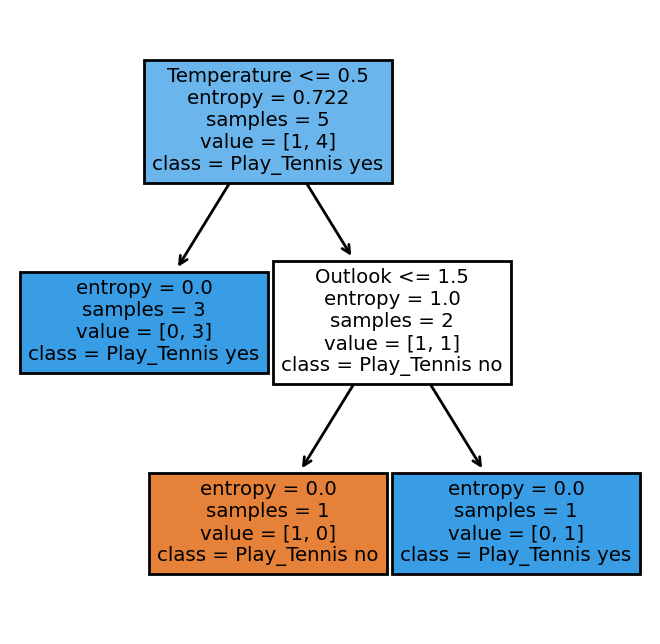

In [18]:
features=["Outlook", "Temperature"]
labels=['Play_Tennis no', 'Play_Tennis yes']

fig, axes = plt.subplots(nrows = 1,ncols = 1,figsize = (4,4), dpi=200)
tree.plot_tree(dtc,
               feature_names = features, 
               class_names=labels,
               filled = True);
# fig.savefig('dtc_small_dataset.png')

In [19]:
dtc.predict(X)

array([0, 1, 1, 1, 1])

In [20]:
from sklearn.metrics import accuracy_score
accuracy_score(y, dtc.predict(X))

1.0